This notebook takes 2 signals/images. The intrinsic signal is given in the "intrinsic_func".

In [2]:
%reset -f
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np

In [85]:
%matplotlib inline
def intrinsic_func(t,mu,dt):
    return mu*np.sin(t+dt)/np.sqrt(t+dt)

t_max=10.0; t_min=0.0; t_range=t_max-t_min; Ndata=200;
t=t_min+np.random.rand(Ndata)*t_range;t=np.sort(t)
sigft=0.2+np.random.rand(len(t))
#a slight shift is given because fitting may have problem with a very small \sigma 
print(np.amin(t), np.amax(t))


0.05669961805835566 9.973213458013689


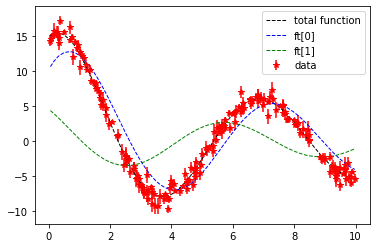

In [86]:
#mu and dt for the images
mu_l=[15.0,7.5,3.5,9.0]
dt_l=[0.5,2.07,0.5,-1.57]
#for simplicity just consider the 1st NI images for now
NI=2; #just take two signal/image 
ft=np.zeros((NI,Ndata))
for i in np.arange(NI): 
    ft[i]=intrinsic_func(t,mu_l[i],dt_l[i])
    
ft_total=np.sum(ft,axis=0)

y=np.random.normal(ft_total, sigft)#this is my data

plt.errorbar(t,y,yerr=sigft,fmt='r*',label=r"data") #data
plt.plot(t,ft_total,c='k',lw=1.0,ls="--", label=r"total function")
clr=["b","g","c"]
for i in range(NI):
    plt.plot(t,ft[i],c=clr[i],lw=1.0,ls="--", label=r"ft[%d]"%(i))

plt.legend(loc=0)
plt.show()

In [87]:
#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('mu1', 2.0, True, 0.2,20.0),('mu2', 2.0, True, 0.2,20.0))
p.add('dt1', value=0.50, min=0, max=3.0);p.add('dt2', value=0.50, min=0, max=3.0)
def residual(p):
    v = p.valuesdict()
    return (v['mu1']*np.sin(t+v['dt1'])/np.sqrt(t+v['dt1'])
            +v['mu2']*np.sin(t+v['dt2'])/np.sqrt(t+v['dt2']) - y)/sigft


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1000, thin=7, nwalkers=50,
                     params=p, is_weighted=False)
lmfit.report_fit(res.params)

100%|██████████| 1000/1000 [00:05<00:00, 186.91it/s]

[[Variables]]
    mu1:        11.9983944 +/- 2.74081448 (22.84%) (init = 2)
    mu2:        10.8527825 +/- 2.01266330 (18.55%) (init = 2)
    dt1:        0.31590111 +/- 0.13590130 (43.02%) (init = 0.5)
    dt2:        1.73764134 +/- 0.29205358 (16.81%) (init = 0.5)
    __lnsigma:  0.07781775 +/- 0.06796873 (87.34%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu1, dt2)       =  0.984
    C(mu1, mu2)       = -0.923
    C(mu2, dt2)       = -0.883
    C(mu1, __lnsigma) = -0.632
    C(mu1, dt1)       = -0.631
    C(dt2, __lnsigma) = -0.623
    C(dt1, dt2)       = -0.559
    C(dt1, __lnsigma) =  0.548
    C(mu2, __lnsigma) =  0.526
    C(mu2, dt1)       =  0.493


odict_values([11.998394447730037, 10.852782538229164, 0.31590111098573537, 1.7376413406941456, 0.07781774628709268])


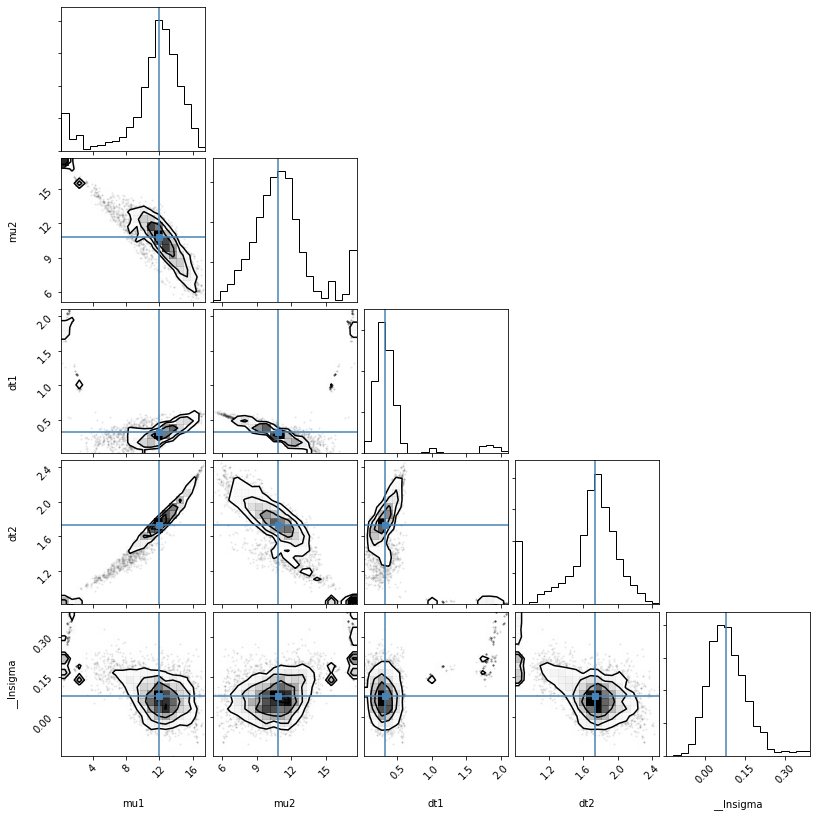

In [88]:
import corner
print(res.params.valuesdict().values())
emcee_plot = corner.corner(res.flatchain, labels=res.var_names,
                           truths=list(res.params.valuesdict().values()))

Upto this point we see that the MCMC (emcee) works well to fit multiple signals when we assume the correct template for the intrinsic signal.


In [89]:
#pystan: assuming the model=mu*sin(t+dt)/np.sqrt(t+dt);
model = """
data {
    int<lower=0> N;
    int<lower=0> ni;
    vector[N] t;
    vector[N] y;
    vector[N] yerror;
}
parameters {
    real<lower=0.2, upper=20> mu[ni];
    real <lower=0, upper=3> dt[ni];
    
}
model {
    real dum;
    for(i in 1:N) {
    
        dum=0;
        for(j in 1:ni)
        {
            dum=dum+mu[j]*sin(t[i]+dt[j])/sqrt(t[i]+dt[j]);
        }
        
        //y[i] ~ normal(dum, yerror[i]);
        target+=normal_lpdf(y[i]|dum,yerror[i]);
    }
}
"""
data = {'N': Ndata,'ni':NI, 't': t, 'y': y, 'yerror':sigft}#NI=2

sm = pystan.StanModel(model_code=model)

fit = sm.sampling(data=data, iter=3000, chains=4, warmup=400, thin=3, seed=18371)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b70f51b44becfd9c545ee9518780e5f NOW.


Inference for Stan model: anon_model_8b70f51b44becfd9c545ee9518780e5f.
4 chains, each with iter=3000; warmup=400; thin=3; 
post-warmup draws per chain=867, total post-warmup draws=3468.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]    9.7    0.05   1.72    6.0   8.54   9.85  10.99  12.59   1292    1.0
mu[2]  13.39    0.05    1.7  10.29  12.13  13.36  14.52  16.87   1247   1.01
dt[1]    1.9  5.7e-3    0.2   1.59   1.75   1.87    2.0   2.38   1240   1.01
dt[2]   0.35  3.1e-3   0.11   0.16   0.27   0.35   0.43   0.58   1280    1.0
lp__  -202.7    0.04   1.56 -206.7 -203.4 -202.3 -201.5 -200.8   1669    1.0

Samples were drawn using NUTS at Wed Nov 20 18:19:00 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Although pystan recovers reasonably correct vlues, we also (sometimes) see that it struggles (Rhat does not always converge to 1) when we include multiple time delays even if we assume the correct intrinsic function. Below we show that the pystan gives us correct values when we fix any one dt to its correct value. 

In [91]:
#pystan: assuming the model=mu*sin(t+dt)/np.sqrt(t+dt);
model = """
data {
    int<lower=0> N;
    int<lower=0> ni;
    vector[N] t;
    vector[N] y;
    vector[N] yerror;
}
parameters {
    real<lower=0.2, upper=20> mu[ni];
    real dt;
    
}
model {
    real dum;
    real dt_dum;
    for(i in 1:N) {
    
        dum=0;
        dt_dum=0.5;
        for(j in 1:ni)
        {
            if(j==2){dt_dum=dt;}
            dum=dum+mu[j]*sin(t[i]+dt_dum)/sqrt(t[i]+dt_dum);
        }
        
        //y[i] ~ normal(dum, yerror[i]);
        target+=normal_lpdf(y[i]|dum,yerror[i]);
    }
}
"""
data = {'N': Ndata,'ni':NI, 't': t, 'y': y, 'yerror':sigft}

sm = pystan.StanModel(model_code=model)

fit1 = sm.sampling(data=data, iter=3000, chains=4, warmup=400, thin=3, seed=18371)
print(fit1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_426ebafd72cd87e155e8167c6ff55f83 NOW.


Inference for Stan model: anon_model_426ebafd72cd87e155e8167c6ff55f83.
4 chains, each with iter=3000; warmup=400; thin=3; 
post-warmup draws per chain=867, total post-warmup draws=3468.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]  15.47    0.02   0.66  14.09  15.06   15.5  15.92  16.66   1635    1.0
mu[2]   7.38  3.9e-3   0.16   7.09   7.27   7.37   7.48   7.75   1791    1.0
dt      2.12  2.9e-3   0.12   1.88   2.05   2.13    2.2   2.33   1656    1.0
lp__  -202.0    0.03   1.29 -205.3 -202.6 -201.7 -201.1 -200.5   1920    1.0

Samples were drawn using NUTS at Wed Nov 20 18:22:02 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Now we will move to our requirements. Now we assume NP parameters (free nodes) insted of any template, and perform interpolation. We are again trying to fit 2 signals/images.

**The main question is how many amplitudes $\mu$'s and time delay $dt$'s to consider? For our knowledge with fitting one signal, we guess that there should be one $\mu$ and one $dt$ (for dealing with 2 images/signals). Otherwise there will be degeneracy again. If we have one mu and one dt, we expect that they would represent relative amplitude $(\mu_2/\mu_1)$ and time delay $(dt_2/dt_1)$. But here the code does not know which one is the 1st image and which is the 2nd one. So I am bit unsure here (and I also expect degeneracy in the total parameter space).**

In [126]:
#pystan: modelling the intrinsic function with NP parameters and interpolation
model = """
data {
    int<lower=0> N;
    int<lower=0> ni;
    int<lower=5> NP;
    vector[N] t;
    vector[N] y;
    vector[N] yerror;
    real dt_min;
    real dt_max;
    real trange;
}
parameters {
    real<lower=0.1, upper=5.0> mu [ni-1];#actually measuring amplitudes relative  
    real <lower=dt_min, upper=dt_max> dt[ni-1];#for simplicity just consider dt>0
    real sig;
    vector <lower=-15.0, upper=15.0> [NP] P;
    
    
}
model {
    real dum;
    real td=(trange+dt_max-dt_min)/(NP-1);
    real dum_t;
    int ti;
    real dtt;
    real mu1;
    
    real mod_intr_f;
    
    for(i in 1:N) {
        dum=0;
        for (j in 1:ni){
            dum_t=t[i];
            if(j==1){dtt=0; mu1=1.0;}
            else {dtt=dt[j-1]; mu1=mu[j-1];}
            
            dum_t=dum_t+dtt;
            ti=1;
            //because there is no real to int conversion in stan we have to do it in this way
            while(dum_t>ti*td){
                ti=ti+1;
            }
            mod_intr_f=P[ti+1]+((P[ti+1]-P[ti])/td)*(dum_t-ti*td);//interpolation
            dum+=mu1*mod_intr_f;
        }
        target+=normal_lpdf(y[i]|dum, sqrt(yerror[i]*yerror[i]+sig*sig));
    }
}
"""
dt_min=0.0; dt_max=3.0;
NP=27; 
#NI=2
data = {'N': len(t),'ni':NI,'NP':NP, 't': t, 'y': y, 'yerror':sigft,'dt_min':dt_min, 'dt_max':dt_max, 'trange':t_range}

sm = pystan.StanModel(model_code=model)

fit2 = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=187201)
print(fit2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ea45de2509b8b87acc821f4286b98877 NOW.


Inference for Stan model: anon_model_ea45de2509b8b87acc821f4286b98877.
4 chains, each with iter=2000; warmup=400; thin=3; 
post-warmup draws per chain=534, total post-warmup draws=2136.

         mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
mu[1]    0.32    0.04   0.17   0.11   0.19    0.28   0.41   0.73     20   1.14
dt[1]     1.0    0.05   0.46   0.32   0.56     1.0   1.36   2.01     72   1.06
sig   -1.6e-3  2.7e-3   0.11  -0.22  -0.08 -3.9e-3   0.08   0.22   1713    1.0
P[1]    11.46    0.19   1.48   8.06  10.54   11.69  12.61  13.65     58   1.07
P[2]    13.28     0.1   1.42   9.61  12.58   13.62  14.32  14.95    193   1.04
P[3]    11.78    0.12   1.23   9.06  11.07   11.89  12.55  14.39    111   1.02
P[4]     8.19    0.15   1.28   5.91   7.43    8.11   8.85  11.47     71   1.04
P[5]      4.4    0.16   1.17   2.88   3.54    4.17   4.97    7.6     56   1.09
P[6]    -0.32    0.18   1.17  -1.84   -1.1   -0.56    0.2   2.74     43   1.12
P[7]    -4.13    0.21  

Pystan struggles to converge. But the major problem is we don't know what the mu and dt mean here; it should mean relative alplitude $(\mu_i/\mu_j)$ and time delay $(dt_i-dt_j)$, but with respect to which signal/image (first or second)?

31 27
P's are calculated at t=  [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13. ]
chi^2: pystan reconstruction: 235.1238239366524 reduced chi^2 1.3749931224365637
chi^2: if actual model: 231.2319819312427 reduced chi^2 1.1561599096562134


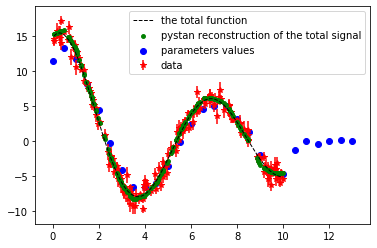

In [128]:
#reconstructing what we obtain
import sys
def interpolation(xp, Pp, xs):
    Ps=np.zeros(len(xs));
    for i in range(len(xs)):
        xxs=xs[i];
        j=1;
        while xxs>xp[j]:
                j+=1;
        Ps[i]=Pp[j]+(xxs-xp[j])*(Pp[j]-Pp[j-1])/(xp[j]-xp[j-1])
    return Ps


pp1=fit2.get_posterior_mean()
pos_mean=np.mean(pp1,axis=1)
P_mean=pos_mean[np.arange(3,len(pos_mean)-1)]; 
print(len(pos_mean),len(P_mean))


#sys.exit()
tp=np.linspace(0,t_range+dt_max-dt_min,NP)
print("P's are calculated at t= ",tp)

plt.errorbar(t,y,yerr=sigft,fmt='r*',label="data")
plt.plot(t,ft_total,c='k',lw=1.0,ls="--",zorder=4, label="the total function")

Ps1=interpolation(tp, P_mean, t)#1st signal/image according to pystan
Ps2=pos_mean[0]*interpolation(tp, P_mean, t+pos_mean[1])#2nd signal/image according to pystan

rconst_signal=Ps1+Ps2;
chi2_rs=np.sum(((y-rconst_signal)/sigft)**2)

print("chi^2: pystan reconstruction:",chi2_rs,"reduced chi^2", chi2_rs/(len(t)-NP-2))
chi2_am=np.sum(((y-ft_total)/sigft)**2)
print("chi^2: if actual model:",chi2_am,"reduced chi^2", chi2_am/len(t))

"""
#values from emcee (MCMC) fitting assuming the correct intrinsic model:
m1,m2,dt2=10.262215075894197, 14.881417947925575, 1.588
mcmc_rec=intrinsic_func(x,m1,0)+intrinsic_func(x,m2,dt2)
chi2_fit=np.sum(((y-mcmc_rec)/sigfx)**2)
print("chi^2: if MCMC fitting:",chi2_fit, chi2_fit/(len(x)-3))"""

plt.scatter(t,Ps1+Ps2,c='g',s=15.0,zorder=3, label="pystan reconstruction of the total signal")

plt.scatter(tp,P_mean,c='b',label="parameters values")
plt.legend()
plt.show()

The above shows that whaterever the pystan has estimated, it is not bad...just I am not completely sure if I am estimating $\mu$ and $dt$ correctly.

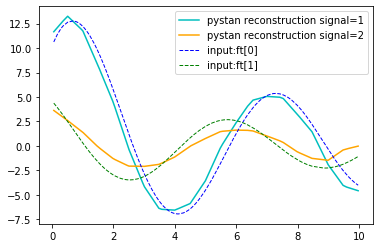

In [136]:
plt.plot(t,Ps1,c='c',zorder=1, label="pystan reconstruction signal=1")
plt.plot(t,Ps2,c='orange',zorder=2, label="pystan reconstruction signal=2")
for i in range(NI):
    plt.plot(t,ft[i],c=clr[i],lw=1.0,ls="--", label=r"input:ft[%d]"%(i))
    
plt.legend()
plt.show()

**The good thing is that pystan reconstructions of the signals trace our input signals fairly well.** In that case we have to say that the estimated time delay is quite off though.

In [131]:
#pystan: modelling the intrinsic function with NP parameters and 2 mu , 2 dt
model = """
data {
    int<lower=0> N;
    int<lower=0> ni;
    int<lower=5> NP;
    vector[N] t;
    vector[N] y;
    vector[N] yerror;
    real dt_min;
    real dt_max;
    real trange;
}
parameters {
    real<lower=0.1, upper=20.0> mu [ni];#expect degeneracy  
    real <lower=dt_min, upper=dt_max> dt[ni];#for simplicity just consider dt>0
    real sig;
    vector <lower=-15.0, upper=15.0> [NP] P;
    
    
}
model {
    real dum;
    real td=(trange+dt_max-dt_min)/(NP-1);
    real dum_t;
    int ti;
    
    real mod_intr_f;
    
    for(i in 1:N) {
        dum=0;
        for (j in 1:ni){
            dum_t=t[i];            
            dum_t=dum_t+dt[j];
            ti=1;
            //because there is no real to int conversion in stan we have to do it in this way
            while(dum_t>ti*td){
                ti=ti+1;
            }
            mod_intr_f=P[ti+1]+((P[ti+1]-P[ti])/td)*(dum_t-ti*td);//interpolation
            dum+=mu[j]*mod_intr_f;
        }
        target+=normal_lpdf(y[i]|dum, sqrt(yerror[i]*yerror[i]+sig*sig));
    }
}
"""
dt_min=0.0; dt_max=3.0;
NP=27; 
#NI=2
data = {'N': len(t),'ni':NI,'NP':NP, 't': t, 'y': y, 'yerror':sigft,'dt_min':dt_min, 'dt_max':dt_max, 'trange':t_range}

sm = pystan.StanModel(model_code=model)

fit3 = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=187201)
print(fit3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_13ed6128f9c82a6d86b9f912606a62b3 NOW.


Inference for Stan model: anon_model_13ed6128f9c82a6d86b9f912606a62b3.
4 chains, each with iter=2000; warmup=400; thin=3; 
post-warmup draws per chain=534, total post-warmup draws=2136.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]   0.59  6.7e-3    0.1    0.4   0.53   0.59   0.64    0.8    216   1.04
mu[2]   0.58  6.2e-3   0.09   0.41   0.52   0.57   0.63   0.77    221   1.04
dt[1]   1.26     0.5   0.77   0.39    0.6   1.03   1.85   2.95      2   2.76
dt[2]   1.41    0.39   0.68   0.03   0.98   1.52   1.94   2.56      3   1.92
sig   7.6e-3  6.3e-3   0.12  -0.22  -0.08 8.5e-3    0.1   0.23    367   1.02
P[1]    1.45    0.59   8.76 -14.18  -5.85    1.9   9.71  14.17    217   1.01
P[2]    5.06    2.97   8.98 -13.75   -1.9   9.12  12.44  14.65      9   1.18
P[3]     8.8     3.7   7.95 -13.03   7.39  12.35  14.07  14.92      5   1.41
P[4]   11.49    1.32   5.06  -7.98  11.23  12.95  14.08  14.92     15    1.2
P[5]   11.16    1.11   3.55   4.24   9.15  

Now we still don't know what $\mu[]$ and $dt[]$ mean. The values are highly prior dependent now. 

33 27
P's are calculated at t=  [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13. ]
chi^2: pystan reconstruction: 812.6161933659553 reduced chi^2 4.808379842402102
chi^2: if actual model: 231.2319819312427 reduced chi^2 1.1561599096562134


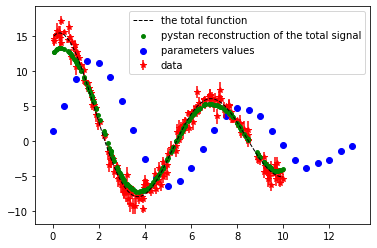

In [137]:
#reconstructing what we obtain
import sys
def interpolation(xp, Pp, xs):
    Ps=np.zeros(len(xs));
    for i in range(len(xs)):
        xxs=xs[i];
        j=1;
        while xxs>xp[j]:
                j+=1;
        Ps[i]=Pp[j]+(xxs-xp[j])*(Pp[j]-Pp[j-1])/(xp[j]-xp[j-1])
    return Ps


pp1=fit3.get_posterior_mean()
pos_mean=np.mean(pp1,axis=1)
P_mean=pos_mean[np.arange(5,len(pos_mean)-1)]; 
print(len(pos_mean),len(P_mean))


#sys.exit()
tp=np.linspace(0,t_range+dt_max-dt_min,NP)
print("P's are calculated at t= ",tp)
plt.errorbar(t,y,yerr=sigft,fmt='r*',label="data")
plt.plot(t,ft_total,c='k',lw=1.0,ls="--",zorder=4, label="the total function")

Ps1=pos_mean[0]*interpolation(tp, P_mean, t+pos_mean[2])#1st signal/image according to pystan
Ps2=pos_mean[1]*interpolation(tp, P_mean, t+pos_mean[3])#2nd signal/image according to pystan

rconst_signal=Ps1+Ps2;
chi2_rs=np.sum(((y-rconst_signal)/sigft)**2)

print("chi^2: pystan reconstruction:",chi2_rs,"reduced chi^2", chi2_rs/(len(t)-NP-4))
chi2_am=np.sum(((y-ft_total)/sigft)**2)
print("chi^2: if actual model:",chi2_am,"reduced chi^2", chi2_am/len(t))

"""
#values from emcee (MCMC) fitting assuming the correct intrinsic model:
m1,m2,dt2=10.262215075894197, 14.881417947925575, 1.588
mcmc_rec=intrinsic_func(x,m1,0)+intrinsic_func(x,m2,dt2)
chi2_fit=np.sum(((y-mcmc_rec)/sigfx)**2)
print("chi^2: if MCMC fitting:",chi2_fit, chi2_fit/(len(x)-3))"""

plt.scatter(t,Ps1+Ps2,c='g',s=15.0,zorder=3, label="pystan reconstruction of the total signal")

plt.scatter(tp,P_mean,c='b',label="parameters values")
plt.legend()
plt.show()

The pystan reconstruction is not good anymore. Possibly, the best-fit values of mu and dt would give a better match to the data.